In [21]:
import sys, struct, logging
import io, time, imageio, os
from datetime import timedelta
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
if "__file__" not in dir():
    %run UtilityTools.ipynb

In [22]:
class SeqFileFormat:
    HEADER={
        'numOfFrames':  {'offset':572, 'L':4, 'format':'=L'},
        'headerSize':   {'offset': 32, 'L':4, 'format':'=l'},
        'fixedSize':    {'offset':600, 'L':4, 'format':'=L'},
        'timeOffset':   {'offset':612, 'L':4, 'format':'=l'},
        'compression':  {'offset':620, 'L':4, 'format':'=l'},
    }
    
    TIMESTAMP={
        'offset':0,
        'L':8,
        'format':'=lHH'
    }
    
    FRAMERATE={
        'slow':20,
        'fast':200
    }
    
    def __init_subclass__(cls,*args):
        assert hasattr(cls, '__enter__'), f"{cls.__name__} is not a context manager!"
        
    def _read_frame_size(self):
        fameSizeByte=self.file.read(4)
        
        return int.from_bytes(fameSizeByte,sys.byteorder)-4
    
    def _read_timestamp(self):
        timestampByte=self.file.read(self.TIMESTAMP['L'])
        timestamp=struct.unpack(self.TIMESTAMP['format'],timestampByte)
        
        time=timedelta(seconds=timestamp[0], milliseconds=timestamp[1], microseconds=timestamp[2])
        
        return time

In [23]:
class SeqFile(SeqFileFormat):
    """
    This class implements basic methods to extract single frames from a 
    norpix *.SEQ movie file WITH jpeg compression.
    Interface:
    with SeqFile(path_to_file) as f:
        f.goto_time (time_to_go_to_as_a_deltatime_object) OR f.goto_frame(frame_number)
        frameImage, timeStamp = f.get_frame()
    """

    def __init__(self, filePath):
        self.filePath=filePath
        
    def __len__(self):
        return self.num_of_frames()
    
    def __str__(self):
        return f".SEQ file at {self.filePath}"
        
    def _peek(self, size, offset, from_what=0):
        """
        read a few bytes from an offset without moving the file pointer
        """
        f_init=self.file.tell()
        try:
            self.file.seek(offset, from_what)
            data=self.file.read(size)
        finally:
            self.file.seek(f_init)
            
        return data
        
    def __enter__(self):
        try:
            self.file = open(self.filePath,'rb')
            self.frame=np.inf
            self.time = timedelta.max
        except Exception as e:
            logging.error(f"file: {self.filePath} failed to open!\n{repr(e)}")
            return None
        
        return self

    def __exit__(self, *args):
        try:
            self.file.close()
        except AttributeError:
            #when there is an error in opening the file, so there is no close() method
            pass
    
    def num_of_frames(self):
        data= self._peek(self.HEADER['numOfFrames']['L'],self.HEADER['numOfFrames']['offset'])
        return struct.unpack(self.HEADER['numOfFrames']['format'],data)[0]
    
    def time_offset(self):
        """
        this method returns the timestamp of the first frame
        """
        headerByte=self._peek(self.HEADER['headerSize']['L'],self.HEADER['headerSize']['offset'])
        headerSize=struct.unpack(self.HEADER['headerSize']['format'],headerByte)[0]

        frame1sizeByte=self._peek(4,headerSize)
        frame1size=int.from_bytes(frame1sizeByte,sys.byteorder)-4

        timeByte=self._peek(self.TIMESTAMP['L'],headerSize+4+frame1size)
        timestamp=struct.unpack(self.TIMESTAMP['format'],timeByte)
        
        time=timedelta(seconds=timestamp[0], milliseconds=timestamp[1], microseconds=timestamp[2])
        return time

    def get_frame(self):
        """
        this method yields one frame image.
        the pointer must be at the begining of a frame (frame size byte)
        reaching the end will raise an error
        """
        frameSize=self._read_frame_size()
        imageByte=self.file.read(frameSize)
        
        image = Image.open(io.BytesIO(imageByte))
        timestamp=self._read_timestamp()-self.time_offset()
        
        self.frame+=1
        self.time=timestamp
        return image, timestamp

    def goto_frame(self,N=1):
        """
        This method browses the pointer to the begining of the N_th frame
        """
        headerByte=self._peek(self.HEADER['headerSize']['L'],self.HEADER['headerSize']['offset'])
        headerSize=struct.unpack(self.HEADER['headerSize']['format'],headerByte)[0]
        #pre-allocation to incease the speed
        timestampL=self.TIMESTAMP['L']
        byteorder= sys.byteorder
        file=self.file
        
        if N<self.frame:
            n=1
            file.seek(headerSize)
        elif N==self.frame:
            return
        else:
            n=self.frame
        while n<N:
            fameSizeByte=file.read(4)
            frameSize= int.from_bytes(fameSizeByte,byteorder)-4
            file.seek(frameSize+timestampL,1)
            n+=1
        logging.info(f'current frame:{n}')
        self.frame=N
        
        timeByte=self._peek(self.TIMESTAMP['L'],-self.TIMESTAMP['L'],1)
        timestamp=struct.unpack(self.TIMESTAMP['format'],timeByte)        
        time=timedelta(seconds=timestamp[0], milliseconds=timestamp[1], microseconds=timestamp[2])-self.time_offset()
        self.time =time
            
    def goto_time(self,T=0):
        """
        this method browses the file to the begining of a frame, closest to the time T
        It will be less accurate for intertrials
        """
        if T==0:
            T=self.time_offset()
        
        assert isinstance(T,timedelta), 'Bad time format'
        
        if T.days >= 1: #in case T is not relative to first frame
            T=T-self.time_offset()
            
        headerByte=self._peek(self.HEADER['headerSize']['L'],self.HEADER['headerSize']['offset'])
        headerSize=struct.unpack(self.HEADER['headerSize']['format'],headerByte)[0]
        #pre-allocation to incease the speed
        timestampL     =self.TIMESTAMP['L']
        timestampFormat=self.TIMESTAMP['format']
        byteorder= sys.byteorder
        file=self.file
        refTime=self.time_offset()
        halfInterval= timedelta(seconds=1/(2*self.FRAMERATE['fast']))
        
        if T< self.time:
            dt=timedelta(days=2)
            frame=1
            file.seek(headerSize)
        elif T==self.time:
            return
        else:
            frame=self.frame
            dt=T-self.time
        
        zero=timedelta()
        while dt >= halfInterval:
            fameSizeByte=file.read(4)
            frameSize= int.from_bytes(fameSizeByte,byteorder)-4
            file.seek(frameSize,1)
            timeByte=file.read(timestampL)
            timestamp=struct.unpack(timestampFormat,timeByte)
            time=timedelta(seconds=timestamp[0], milliseconds=timestamp[1], microseconds=timestamp[2])-refTime
            dt=T-time
            frame+=1
        
        file.seek(-(frameSize+timestampL+4),1)
        logging.info(f'current time:{time}')
        self.time=time-timedelta.resolution
        self.frame=frame-1
    
    @classmethod
    def open(cls, *arg, **kw):
        obj=cls(*arg, **kw)
        return obj.__enter__()
            

This class processes the video

In [63]:
class SeqProcess:
    """
    This class will implement methods to extract multiple frames and save them as viedos etc.
    """
    def __init__(self,seq):
        assert isinstance(seq,SeqFile), "Input must be a SeqSile object"
        self.file=seq
        try:
            evt=self.read_file(seq.filePath.rstrip('.seq')+'.evt.cam')
            self.camEvent=tuple(evt)
        except:
            self.camEvent=None
    
    def video_epoch(self, t1, t2, fps):
        """
        extracts the video betweeen t1 and t2, and returns the images
        corresponding to fps, fps must be smaller than the video's
        t1,t2: with reference to the Ephy recording (based on .evt.cam file)
        """
        assert isinstance(t1,timedelta), 'Bad time format'
        assert t2>t1, "t2 must be bigger than t1"
        assert fps < self.file.FRAMERATE['fast'], 'FPS too high'
        
        self._time_delay()
        T1=t1-self._delay
        T2=t2-self._delay
        interval=timedelta(seconds=1/fps)
        fix=self.adj_contrast_brightness
        
        im_list=[]
        t=T1-interval
        while t<=T2:
            self.file.goto_time(t+interval)
            im,frame_time=self.file.get_frame()
            im_list.append(fix(im))
            t=frame_time
        
        return tuple(im_list)
        
    def video_epoch_gen(self, t1, t2, fps):
        """
        GENERATOR version of vedeo_epoch
        """
        assert isinstance(t1,timedelta), 'Bad time format'
        assert t2>t1, "t2 must be bigger than t1"
        assert fps < self.file.FRAMERATE['fast'], 'FPS too high'
        
        self._time_delay()
        T1=t1-self._delay
        T2=t2-self._delay
        interval=timedelta(seconds=1/fps)
        fix=self.adj_contrast_brightness
        
        t=T1-interval
        while t<=T2:
            self.file.goto_time(t+interval)
            im,frame_time=self.file.get_frame()
            t=frame_time
            yield fix(im)
        
        return None
        
    
    def _time_delay(self):
        try:
            return self._delay
        except AttributeError:
            #first trial = first frame of the camera
            self._delay=timedelta(milliseconds=self.camEvent[0])
            return self._delay
    
    @staticmethod
    def ephy_sync_to_video(filename,           #str: filename of the ephy data file
                    fs,                        #int: sampling rate of ephy data
                    Nch,                       #int: number of channels of the ephy data
                    wantedCh,                  #list: list of channels to get the ephy data from 
                    t0,                        #float: start time
                    t1,                        #float: end time
                    fps=20):                   #int: number of epochs per second
        """
        This function returns ephy signal epochs sync to 
        each frame extracted from video_epoch
        """
        assert os.path.exists(filename), f'{filename} does not exist'
        assert t1 > t0

        #coefficient of downsampling of the extracted ephy data
        DOWNSAMPLE=5
        #float: size of each window of data in secs
        WIN=2

        step=1/fps
        epoch=lambda t,win: (t-win/2,t+win/2)

        signals={}
        for wCh in wantedCh:
            key=str(wCh)
            signals[key]=[]
            t=t0
            while t<t1:
                t_start, t_end= epoch(t, WIN)
                sig=read_ephy_epoch(filename, fs, Nch, wCh, t_start, t_end)[::DOWNSAMPLE]
                signals[key].append(sig)
                t+=step

        return signals
    
    @staticmethod
    def ephy_sync_to_video_gen(filename,       #str: filename of the ephy data file
                    fs,                        #int: sampling rate of ephy data
                    Nch,                       #int: number of channels of the ephy data
                    wantedCh,                  #list: list of channels to get the ephy data from 
                    t0,                        #float: start time
                    t1,                        #float: end time
                    fps=20):                   #int: number of epochs per second
        """
        This function is the generator version of ephy_sync_to_video
        """
        assert os.path.exists(filename), f'{filename} does not exist'
        assert t1 > t0

        #coefficient of downsampling of the extracted ephy data
        DOWNSAMPLE=5
        #float: size of each window of data in secs
        WIN=2

        step=1/fps
        epoch=lambda t,win: (t-win/2,t+win/2)
        
        t=t0
        while t<t1:
            t_start, t_end= epoch(t, WIN)
            sig=[]
            for wCh in wantedCh:
                sig=read_ephy_epoch(filename, fs, Nch, wCh, t_start, t_end)[::DOWNSAMPLE]
                sig.append(sig)
            t+=step
            yield sig

        return None
    
    @staticmethod
    def read_file(path):
        """reads a one column text file"""
        if not os.path.exists(path):
            logging.error(f"No file {path}")
            raise IOError
        
        a=[]
        with open(path,'rt') as f:
            for line in f:
                a.append(float(line.rstrip('\n').split()[0]))
        return a

    @staticmethod
    def save_gif(ims, filepath, duration=1):
        """
        ims: a list of all Image objects
        duration: a list of the duration each image will be displayed
        """

        assert filepath.endswith('.gif') or filepath.endswith('.GIF'), "Bad file name"
        assert hasattr(ims,'__iter__'), 'images not in an iterator'
    #     assert len(duration)==len(ims) or len(duration)==1

        with imageio.get_writer(filepath, mode='I', format='.gif',
                                subrectangles= True, duration=duration) as writer:
            for im in ims:
                writer.append_data(np.asarray(im))
    
    @staticmethod
    def adj_contrast_brightness(im,cont_fac=1.5,bright_fac=40):
        """Basic Brightness and Contrast adjustment of the images"""
        
#         if not isinstance(im,Image.Image):
#             raise TypeError(f'input must be a PIL.Image object, instead of {im}')

        a=ImageEnhance.Brightness(im)
        im2=a.enhance(bright_fac)
        a=ImageEnhance.Contrast(im2)
        im3=a.enhance(cont_fac)

        return im3

In [25]:
if "__file__" not in dir():
    filePath="/data/Rat106/Experiments/Rat106_2017_03_31_10_56/Rat106_2017_03_31_10_56.seq"
    filePath="/data/Rat174/Experiments/Rat174_2018_05_02_14_29/Rat174_2018_05_02_14_29.seq"
    filePath="/data/Rat172/Experiments/Rat172_2018_02_26_18_15/Rat172_2018_02_26_18_15.seq"
    fix=SeqProcess.adj_contrast_brightness
#     t0=time.perf_counter()
    ims=[]
    with SeqFile(filePath) as f:
        process=SeqProcess(f)
        t0=timedelta(minutes=2,seconds=54,milliseconds=50)
        t1=t0+ timedelta(seconds=4)
        ims=process.video_epoch(t0,t1,20)
        print(len(ims))
#     SeqProcess.save_gif(ims,'/home/david/test.gif',1/20)

82


In [50]:
im1=ims[0]
im2=ims[80]

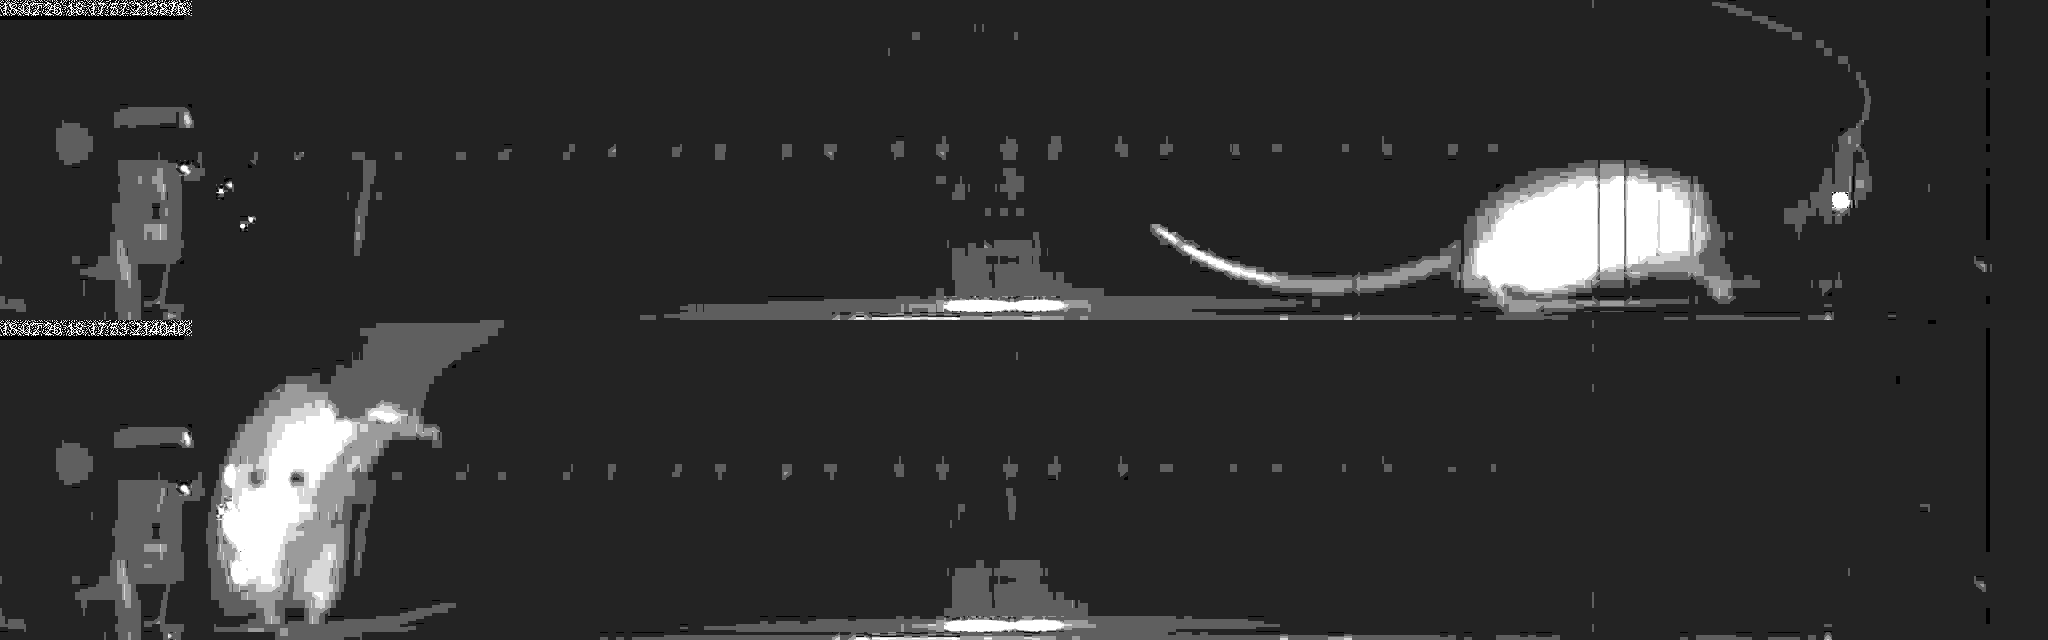

In [51]:
im3 = Image.new('L', (im1.width, im1.height*2))
im3.paste(im1,box=(0,320))
im3.paste(im2,box=(0,0))
im3

In [ ]:
fig=plt.figure(dpi=1000)
ax=fig.add_subplot(111)
ax.plot([1,2,3],[1,5,1],'-ok')
canvas = plt.get_current_fig_manager().canvas
canvas.draw()
pil_image = Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())

In [71]:
file='/data/Rat172/Experiments/Rat172_2018_02_26_18_15/Rat172_2018_02_26_18_15.dat'
sig= SeqProcess.ephy_sync_to_video(file, fs=2e4, Nch=37, wantedCh=[21,22,23,24],t0=175,t1=176,fps=20)

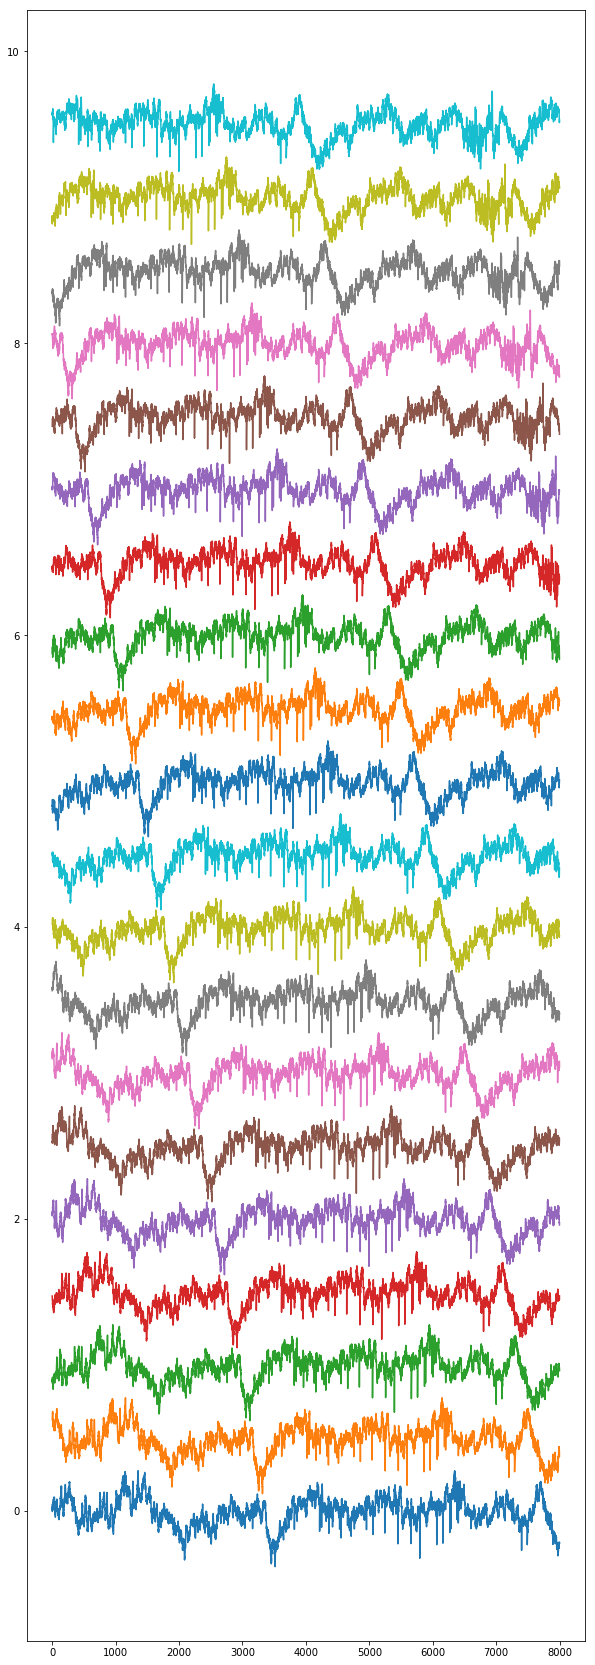

In [78]:
plt.figure(figsize=(10,30))
ax=plt.subplot(111)
for i,epoch in enumerate(sig['22']):
    ax.plot(epoch/5000+(i*.5))

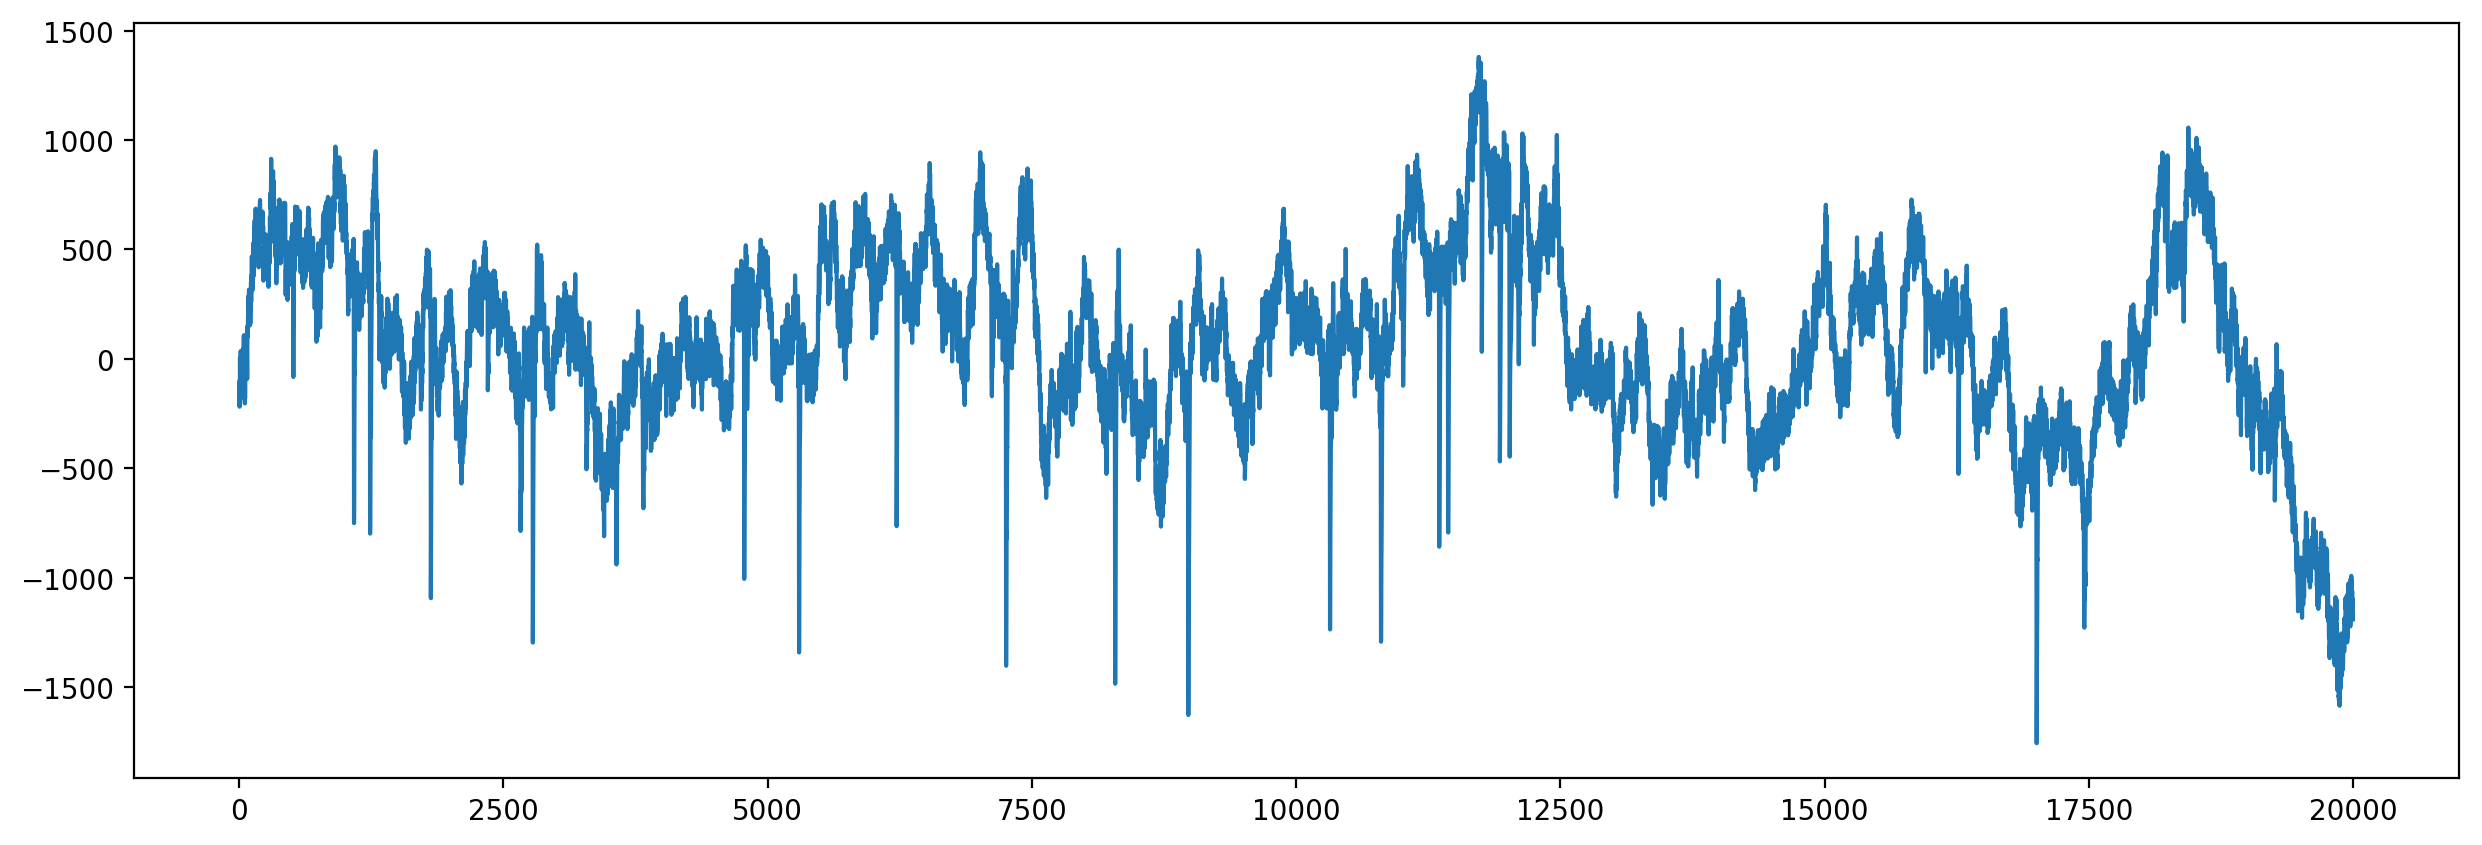

In [46]:
plt.figure(figsize=(15,5),dpi=200);
plt.plot(sig);
# canvas = plt.get_current_fig_manager().canvas;
# canvas.draw();
# pil_image = Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb());